In [1]:
from sklearn.datasets import fetch_covtype
import pandas as pd

# Load the dataset
covtype = fetch_covtype(as_frame=True)  # Returns a DataFrame
X = covtype.data  # Features
y = covtype.target - 1  # Target (adjusted to 0-6 for zero-based indexing)

In [2]:
sample_size = 20000
# Ensure we get a balanced sample across all classes
from sklearn.model_selection import train_test_split
X_sample, _, y_sample, _ = train_test_split(
    X, y, train_size=sample_size, random_state=42, stratify=y
)
X = X_sample
y = y_sample

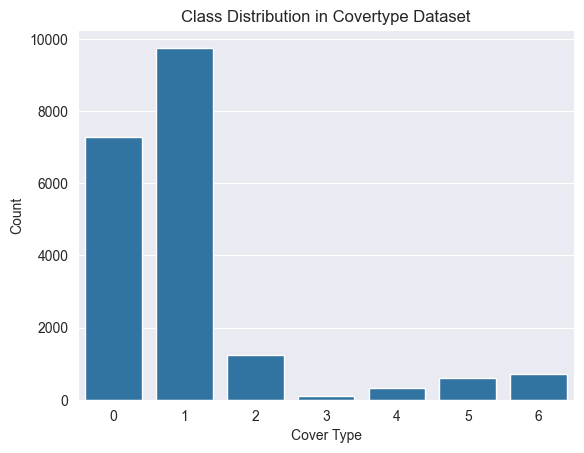

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=y)
plt.title('Class Distribution in Covertype Dataset')
plt.xlabel('Cover Type')
plt.ylabel('Count')
plt.show()

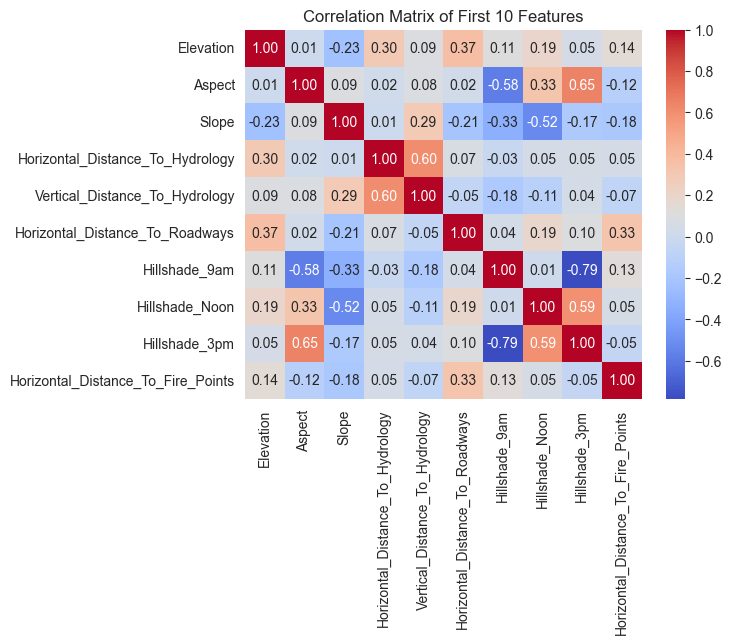

In [4]:
# Select first 10 features for simplicity
subset = X.iloc[:, :10]

# Compute correlation matrix
corr = subset.corr()

# Plot heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of First 10 Features')
plt.show()

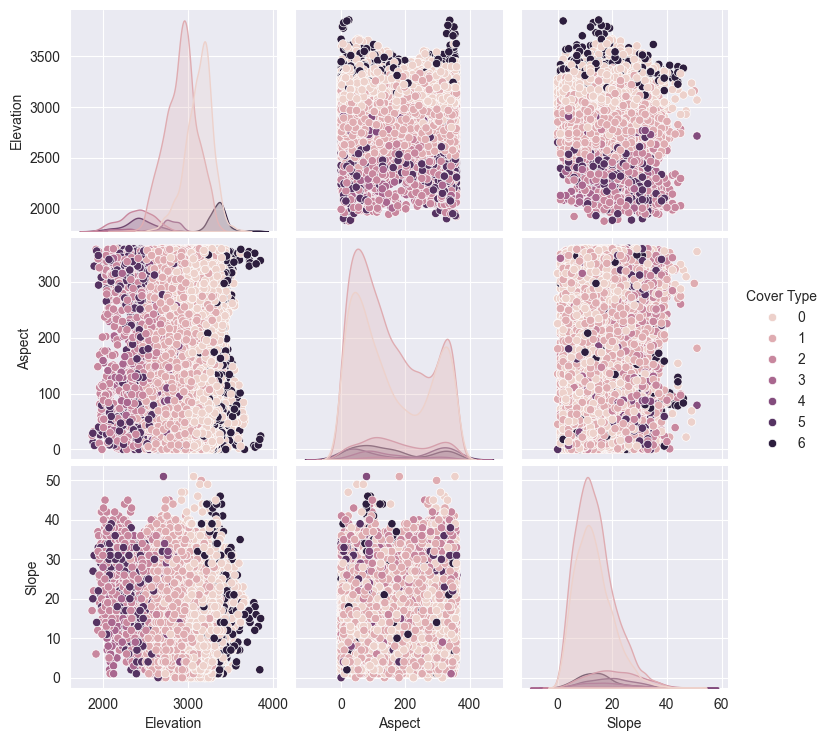

In [5]:
# Combine features and target for a sample
sample = X.iloc[:, :3].copy()  # First 3 features
sample['Cover Type'] = y

sns.pairplot(sample, hue='Cover Type', diag_kind='kde')
plt.show()

In [6]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the dataset into training, validation and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Initialize the CatBoost model with default settings
model = CatBoostClassifier(verbose=0, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
baseline_accuracy = accuracy_score(y_test, y_pred)

print(f"Baseline Accuracy: {baseline_accuracy * 100:.2f}%")

Baseline Accuracy: 83.43%


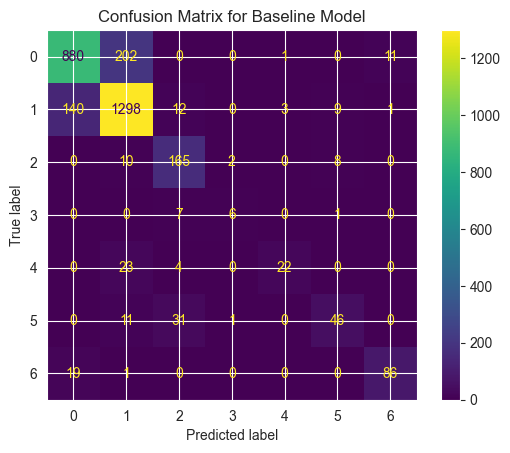

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.title('Confusion Matrix for Baseline Model')
plt.show()

In [8]:
from catboost.utils import get_gpu_device_count

gpu_count = get_gpu_device_count()
if gpu_count > 0:
    print(f"GPU is available. {gpu_count} GPU(s) detected.")
else:
    print("GPU is NOT available.")

GPU is NOT available.


In [9]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score


def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 16),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0, log=True),
        'verbose' : 50,
        'task_type': 'CPU',
        
    }
    
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)
    
    preds = model.predict(X_valid)
    accuracy = accuracy_score(y_valid, preds)
    
    return accuracy

In [ ]:
# Create the study
study_name = 'catboost_optimization'
storage_name = 'sqlite:///example.db'
study = optuna.create_study(
    study_name=study_name,
    storage=storage_name,
    direction='maximize',
    load_if_exists=True
)
study.optimize(objective, n_trials=5)  # Run 20 trials

In [23]:
# Retrieve the best trial from the study
best_trial = study.best_trial

print(f"Best Trial Number: {best_trial.number}")
print(f"Best Validation Accuracy: {best_trial.value:.4f}")
print("Best Hyperparameters Found:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

Best Trial Number: 4
Best Validation Accuracy: 0.8543
Best Hyperparameters Found:
  iterations: 403
  learning_rate: 0.06632951241683728
  depth: 11
  l2_leaf_reg: 0.009764446751340715
  border_count: 250
  bagging_temperature: 0.31113218983027535
  random_strength: 0.06429507498817075


After first 20 trials I am changing max limit of depth, bagging_temperature and random_strength to higher values because they were hitting the boundaries\
Higher limits did not improve model. Best accuracy was still the same. \
I thought that models with greater depth and number of iterations will do better. Maybe they were overfitting? Rest of the parameters looks ok to me.

In [17]:
best_params = best_trial.params

# --- IMPORTANT: Combine Training and Validation Data ---
# Create the full training dataset (train + validation) for the final model
X_train_full = pd.concat([X_train, X_valid], ignore_index=True)
y_train_full = pd.concat([y_train, y_valid], ignore_index=True)

final_params = best_params.copy()
final_params['random_state'] = 42

final_model = CatBoostClassifier(**final_params)
final_model.fit(X_train_full, y_train_full)

0:	learn: 1.7384692	total: 431ms	remaining: 2m 53s
1:	learn: 1.5887126	total: 942ms	remaining: 3m 8s
2:	learn: 1.4716100	total: 1.58s	remaining: 3m 31s
3:	learn: 1.3740797	total: 2.48s	remaining: 4m 7s
4:	learn: 1.2929950	total: 6.78s	remaining: 8m 59s
5:	learn: 1.2233770	total: 7.69s	remaining: 8m 28s
6:	learn: 1.1616426	total: 9s	remaining: 8m 29s
7:	learn: 1.1090194	total: 9.66s	remaining: 7m 56s
8:	learn: 1.0606379	total: 10.1s	remaining: 7m 22s
9:	learn: 1.0180067	total: 10.5s	remaining: 6m 53s
10:	learn: 0.9808431	total: 11s	remaining: 6m 30s
11:	learn: 0.9447997	total: 11.4s	remaining: 6m 10s
12:	learn: 0.9125341	total: 11.8s	remaining: 5m 54s
13:	learn: 0.8840724	total: 12.2s	remaining: 5m 39s
14:	learn: 0.8559029	total: 12.6s	remaining: 5m 27s
15:	learn: 0.8276004	total: 13.1s	remaining: 5m 16s
16:	learn: 0.8046627	total: 13.5s	remaining: 5m 6s
17:	learn: 0.7831339	total: 14s	remaining: 4m 58s
18:	learn: 0.7618932	total: 14.4s	remaining: 4m 51s
19:	learn: 0.7438765	total: 14.8

--- Performance Comparison ---
Baseline Accuracy (on Test Set): 83.43%
Optimized Accuracy (on Test Set): 85.50%
Improvement due to HPO: 2.07%
Confusion Matrix for Final Optimized Model (on Test Set):


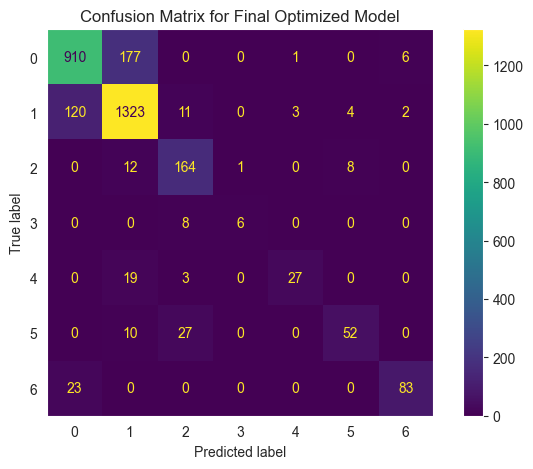

In [18]:
y_pred_test = final_model.predict(X_test)

# Calculate final accuracy
final_accuracy = accuracy_score(y_test, y_pred_test)

print("--- Performance Comparison ---")
# Assuming baseline_accuracy variable holds the score from Step 5
print(f"Baseline Accuracy (on Test Set): {baseline_accuracy * 100:.2f}%")
print(f"Optimized Accuracy (on Test Set): {final_accuracy * 100:.2f}%")
improvement = final_accuracy - baseline_accuracy
print(f"Improvement due to HPO: {improvement * 100:.2f}%")

print("Confusion Matrix for Final Optimized Model (on Test Set):")
ConfusionMatrixDisplay.from_estimator(final_model, X_test, y_test)
plt.title('Confusion Matrix for Final Optimized Model')
plt.tight_layout()
plt.grid(False)
plt.show()

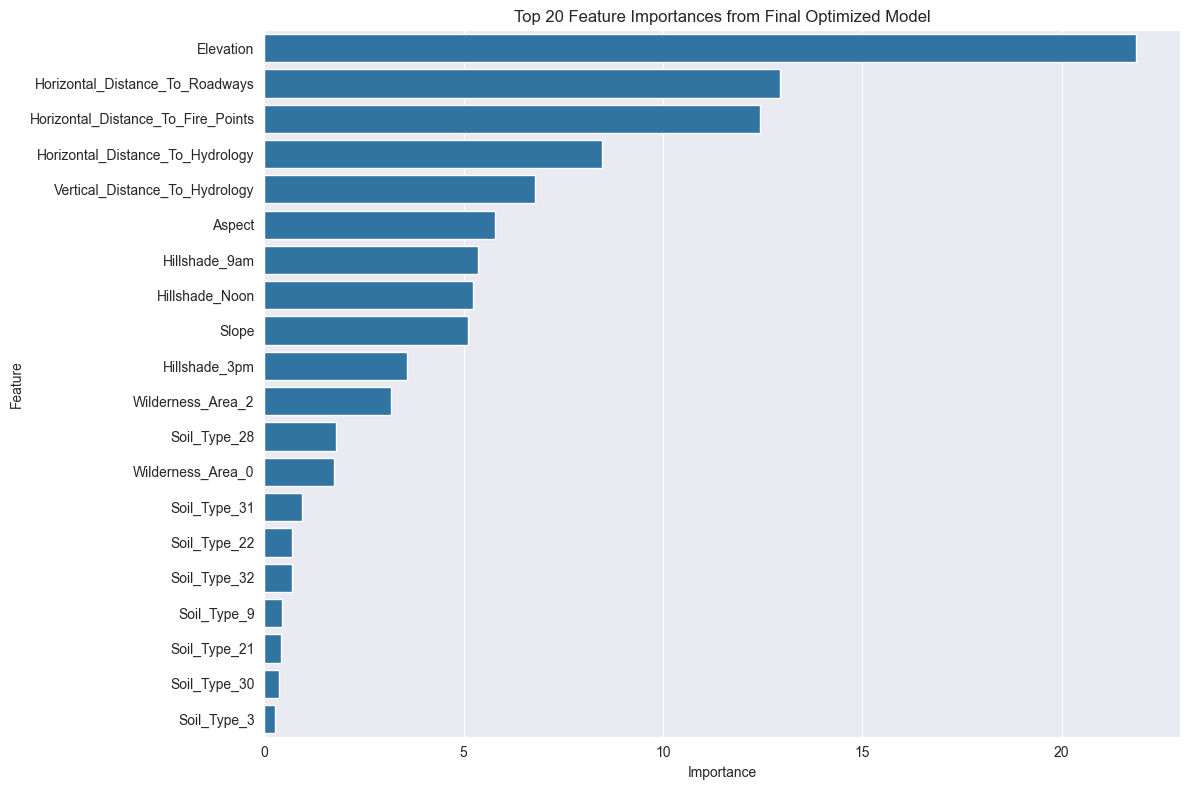

In [19]:
importances = final_model.get_feature_importance()
feature_names = X_train_full.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances (e.g., top 20)
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20)) # Plot top 20
plt.title('Top 20 Feature Importances from Final Optimized Model')
plt.tight_layout()
plt.show()